Copyright 2023 Franco Aquistapace

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Import libraries and code

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

import time

In [2]:
from gaussian_metric import *
from tools import *

# Comparing integration methods

We need to find out what is the best way to integrate functions that take vectors as inputs. First, let's check that both implementations of our functions work properly.

In [3]:
# Build dummy configuration
sc_test = gen_sc_lattice(2,2,2,1)

# Build some positions
p1 = np.array([0,   0,   0  ])
p2 = np.array([0.5, 0,   0  ])
p3 = np.array([0,   0.5, 0  ])
p4 = np.array([0,   0.5, 0.5])
p5 = np.array([1,   1,   1  ])

# Print measure representation values
print('Vector implementation')
for p in [p1,p2,p3,p4,p5]:
    C_rep = measure_representation(p, sc_test)
    print("C(%.1f, %.1f, %.1f) = %.4f" % (*p, C_rep))
print('\nElement-wise implementation')
for p in [p1,p2,p3,p4,p5]:
    C_rep = measure_representation_exp(
        p[0],p[1],p[2], sc_test)
    print("C(%.1f, %.1f, %.1f) = %.4f" % (*p, C_rep))

Vector implementation
C(0.0, 0.0, 0.0) = 1.0056
C(0.5, 0.0, 0.0) = 0.4173
C(0.0, 0.5, 0.0) = 0.4173
C(0.0, 0.5, 0.5) = 0.1732
C(1.0, 1.0, 1.0) = 1.0056

Element-wise implementation
C(0.0, 0.0, 0.0) = 1.0056
C(0.5, 0.0, 0.0) = 0.4173
C(0.0, 0.5, 0.0) = 0.4173
C(0.0, 0.5, 0.5) = 0.1732
C(1.0, 1.0, 1.0) = 1.0056


This seems to be working, now we have to see which integration method is better. We already know that the integration performed by scipy is precise, but we can compare its performance to a more rudimentary integration method. This last method consists of sampling the integration interval, evaluating the function on said points and adding the results, multiplied by the sample volume, to get an estimate of the integral.

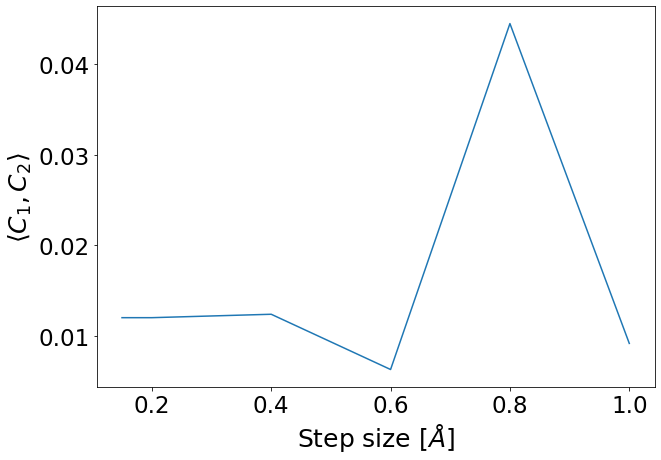

In [4]:
# Test implementation of sampling method, and find out how it converges
sc1 = gen_sc_lattice(2,2,2,1)
sc2 = gen_sc_lattice(2,2,2,1)
sc2 = displace(sc2, np.array([-1.5,-1.5,-1.5]))
margin_size = 2
step_size = [1,0.8,0.6,0.4,0.2,0.15]
dot_sc1_sc2 = [dot(sc1, sc2, s, margin_size) for s in step_size]
# Plot results
FONTSIZE = 25
fig, ax = plt.subplots(figsize=(10,7), nrows=1, ncols=1)
ax.plot(step_size, dot_sc1_sc2)
ax.set_xlabel(r'Step size [$\AA$]', fontsize=FONTSIZE)
ax.set_ylabel(r'$\langle C_1, C_2 \rangle$', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2);

Vector implementation finished in 0.30 s
Element-wise implementation finished in 67.95 s


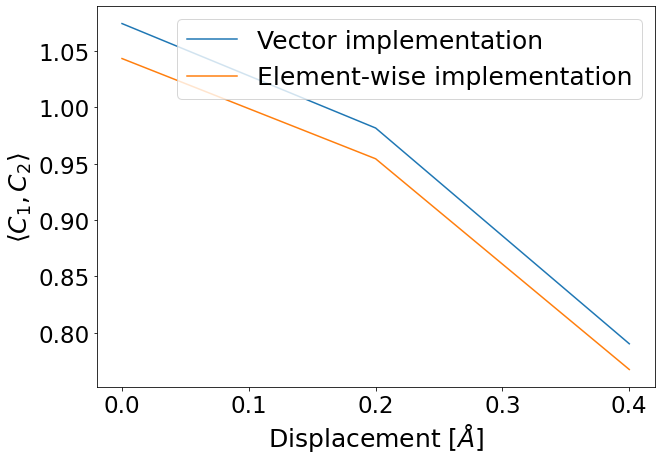

In [5]:
# Comparing the two methods, using step_size = 0.4 for sampling method
margin_size = 2
step_size = 0.4
tol = 0.001
# Generate reference lattice
sc1 = gen_sc_lattice(2,1,1,1)
# Generate multiple displace lattices
disp = [0.2 * n for n in range(3)]
sc2 = [displace(gen_sc_lattice(2,1,1,1), np.array([d,0,0])) for d in disp]
# Get results with both methods
time1 = time.time()
vector_results = [dot(sc1, sc, step_size, margin_size) for sc in sc2]
time2 = time.time()
print('Vector implementation finished in %.2f s' % (time2-time1))
explicit_results = [dot_exp(sc1, sc, margin_size, tol) for sc in sc2]
time3 = time.time()
print('Element-wise implementation finished in %.2f s' % (time3-time2))
# Plot results
FONTSIZE = 25
fig, ax = plt.subplots(figsize=(10,7), nrows=1, ncols=1)
ax.plot(disp, vector_results, label='Vector implementation')
ax.plot(disp, explicit_results, label='Element-wise implementation')
ax.set_xlabel(r'Displacement [$\AA$]', fontsize=FONTSIZE)
ax.set_ylabel(r'$\langle C_1, C_2 \rangle$', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(fontsize=FONTSIZE);

We can already see that the sampling method is at least two orders of magnitude faster than scipy's integrator, and that the results obtained with these two methods are fairly similar. For now, we are going to use the vector implementation (sampling method) moving forward.

# Designing some configurations to test the metric

Let's first see how the metric changes when comparing two identical structures with varying levels of displacement.

Vector implementation finished in 46.99 s


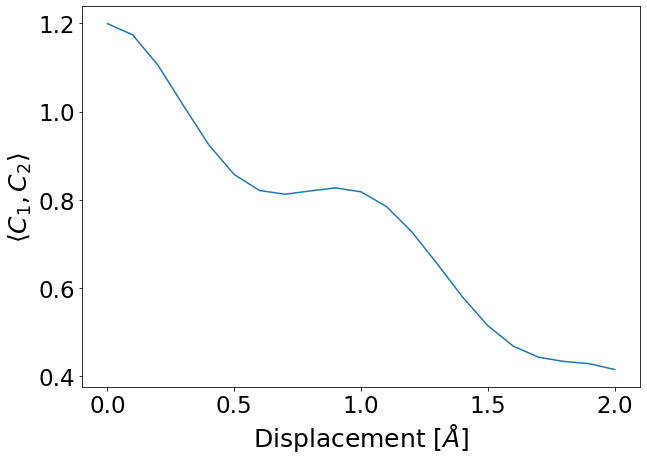

In [6]:
# Set method params
margin_size = 2
step_size = 0.4
# Generate reference lattice
sc1 = gen_sc_lattice(3,3,3,1)
# Generate multiple displace lattices
disp = [0.1 * n for n in range(21)]
sc2 = [displace(gen_sc_lattice(3,3,3,1), np.array([d,0,0])) for d in disp]
# Get results 
time1 = time.time()
vector_results = [dot(sc1, sc, step_size, margin_size) for sc in sc2]
time2 = time.time()
print('Vector implementation finished in %.2f s' % (time2-time1))
# Plot results
FONTSIZE = 25
fig, ax = plt.subplots(figsize=(10,7), nrows=1, ncols=1)
ax.plot(disp, vector_results)
ax.set_xlabel(r'Displacement [$\AA$]', fontsize=FONTSIZE)
ax.set_ylabel(r'$\langle C_1, C_2 \rangle$', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2);

This is interesting! If the lattice was infinite, we would expect $\langle C_1, C_2\rangle$ to be a wave-like function  of the displacement. But since the lattice is finite, the overlap region keeps getting smaller as the displacement increases, and thus we get a decreasing envelope.

Now let's see how the metric changes for different rotations over an axis.

Vector implementation finished in 47.45 s


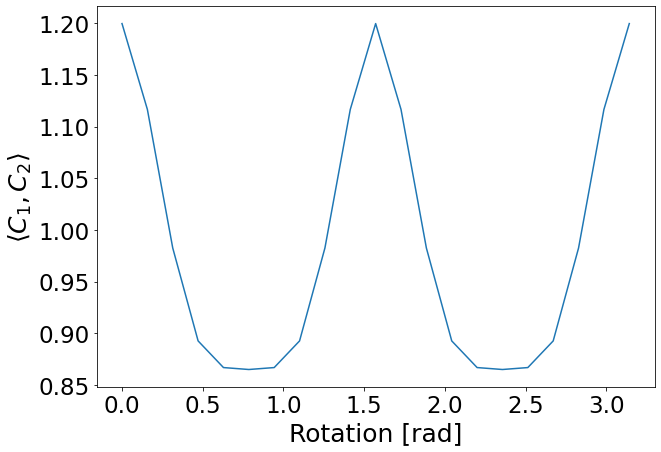

In [7]:
# Set method params
margin_size = 2
step_size = 0.4
# Generate reference lattice
sc1 = gen_sc_lattice(3,3,3,1)
# Displace it so that it's center lies on the origin
center = np.mean(sc1, axis=0)
sc1 = displace(sc1, center*(-1))
# Generate multiple rotated lattices
rot = [np.pi * 0.05 * n for n in range(21)]
sc2 = [rotate(sc1.copy(), r, 0, 0) for r in rot]
# Get results 
time1 = time.time()
vector_results = [dot(sc1, sc, step_size, margin_size) for sc in sc2]
time2 = time.time()
print('Vector implementation finished in %.2f s' % (time2-time1))
# Plot results
FONTSIZE = 25
fig, ax = plt.subplots(figsize=(10,7), nrows=1, ncols=1)
ax.plot(rot, vector_results)
ax.set_xlabel(r'Rotation [rad]', fontsize=FONTSIZE)
ax.set_ylabel(r'$\langle C_1, C_2 \rangle$', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2);

Let's repeat this test to find out how the $M$ metric behaves.

Vector implementation finished in 48.03 s


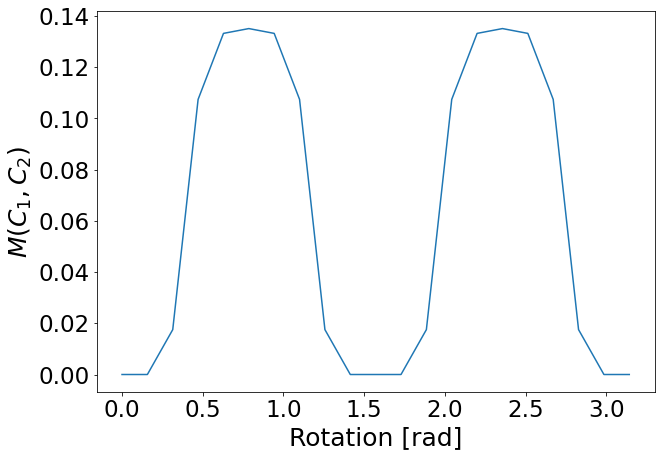

In [8]:
# Set method params
margin_size = 2
step_size = 0.4
# Generate reference lattice
sc1 = gen_sc_lattice(3,3,3,1)
# Displace it so that it's center lies on the origin
center = np.mean(sc1, axis=0)
sc1 = displace(sc1, center*(-1))
# Generate multiple rotated lattices
rot = [np.pi * 0.05 * n for n in range(21)]
sc2 = [rotate(sc1.copy(), r, 0, 0) for r in rot]
# Get results 
time1 = time.time()
vector_results = [M(sc1, sc, step_size, margin_size) for sc in sc2]
time2 = time.time()
print('Vector implementation finished in %.2f s' % (time2-time1))
# Plot results
FONTSIZE = 25
fig, ax = plt.subplots(figsize=(10,7), nrows=1, ncols=1)
ax.plot(rot, vector_results)
ax.set_xlabel(r'Rotation [rad]', fontsize=FONTSIZE)
ax.set_ylabel(r'$M(C_1, C_2)$', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2);